In [42]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import probplot
from scipy.stats import zscore
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten,Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical

In [2]:
df=pd.read_csv("river-historical-1986_2020-en.csv")
#Selectionner seulement les 1900 examples premiers car les autres exemples incorect 
#en plus contient beaucoup des donneés aberantes

In [3]:
# Checking for datatypes of the dataset
df.dtypes

Water Control Zone                             object
River                                          object
Station                                        object
Dates                                          object
Sample No                                       int64
5-Day Biochemical Oxygen Demand (mg/L)        float64
Aluminium (μg/L)                               object
Ammonia-Nitrogen (mg/L)                        object
Anionic Surfactants (as Manoxol OT) (mg/L)     object
Antimony (μg/L)                               float64
Arsenic (μg/L)                                 object
Barium (μg/L)                                 float64
Beryllium (μg/L)                              float64
Boron (μg/L)                                   object
Cadmium (μg/L)                                 object
Chemical Oxygen Demand (mg/L)                  object
Chloride (mg/L)                                object
Chlorophyll-a (μg/L)                          float64
Chromium (μg/L)             

In [4]:
df.shape

(4958, 56)

In [5]:
df = df.copy()
df = df_cleaned_names = df_cleaned_names = df.rename(columns=str.lower)

In [6]:
df=df[['water control zone','river','station','dates','sample no','turbidity (ntu)',
         'suspended solids (mg/l)', 'dissolved oxygen (mg/l)','5-day biochemical oxygen demand (mg/l)',
         'chemical oxygen demand (mg/l)','total organic carbon (mg/l)','total phosphorus (mg/l)',
         'total kjeldahl nitrogen (mg/l)','faecal coliforms (counts/100ml)']]

In [7]:
df.dtypes

water control zone                         object
river                                      object
station                                    object
dates                                      object
sample no                                   int64
turbidity (ntu)                           float64
suspended solids (mg/l)                    object
dissolved oxygen (mg/l)                   float64
5-day biochemical oxygen demand (mg/l)    float64
chemical oxygen demand (mg/l)              object
total organic carbon (mg/l)                object
total phosphorus (mg/l)                    object
total kjeldahl nitrogen (mg/l)             object
faecal coliforms (counts/100ml)            object
dtype: object

In [8]:
#renommer les variables par des target plus simplement à utiliser que les anciennes 
df = df.rename(columns={'turbidity (ntu)': 'turbidity', 'suspended solids (mg/l)': 'ss',
                        'dissolved oxygen (mg/l)': 'dissolved_oxygen',
                        '5-day biochemical oxygen demand (mg/l)': 'bod5',
                        'chemical oxygen demand (mg/l)': 'cod',
                        'total organic carbon (mg/l)': 't_carbon',
                        'total phosphorus (mg/l)': 't_phosphorus',
                        'total kjeldahl nitrogen (mg/l)': 't_nitrogen',
                        'faecal coliforms (counts/100ml)': 'faecal_coliform'})
df.head(5)

,water control zone,river,station,dates,sample no,turbidity,ss,dissolved_oxygen,bod5,cod,t_carbon,t_phosphorus,t_nitrogen,faecal_coliform
0,Junk Bay,Tseng Lan Shue Stream,JR11,4/29/1986,1,4.1,6.5,6.0,9.7,13,<1,2.5,4.1,NaN
1,Junk Bay,Tseng Lan Shue Stream,JR11,5/19/1986,1,4.2,6.5,5.3,5.6,21,5,2,5.1,NaN
2,Junk Bay,Tseng Lan Shue Stream,JR11,6/18/1986,1,5.5,8.5,6.2,9.0,19,1,1.9,3.1,NaN
3,Junk Bay,Tseng Lan Shue Stream,JR11,7/24/1986,1,6.5,6,5.2,12.2,17,<1,2.1,5.5,NaN
4,Junk Bay,Tseng Lan Shue Stream,JR11,8/15/1986,1,6.7,7,5.1,8.8,5,5,4.5,5.3,NaN


In [9]:
#convertir le types des donneés d'un certains variables en float
df['ss'] = pd.to_numeric(df['ss'], errors='coerce')
df['bod5'] = pd.to_numeric(df['bod5'], errors='coerce')
df['cod'] = pd.to_numeric(df['cod'], errors='coerce')
df['t_carbon'] = pd.to_numeric(df['t_carbon'], errors='coerce')
df['t_carbon'].fillna(value=0.9, inplace=True)
df['t_phosphorus'] = pd.to_numeric(df['t_phosphorus'], errors='coerce')
df['t_phosphorus'].fillna(value=0.01, inplace=True)
df['t_nitrogen'] = pd.to_numeric(df['t_nitrogen'], errors='coerce')
df['t_nitrogen'].fillna(value=0.04, inplace=True)
df['faecal_coliform'] = pd.to_numeric(df['faecal_coliform'], errors='coerce')
df['faecal_coliform'] = np.where(df['faecal_coliform'] == '<1', 0.9, df['faecal_coliform'])
df['faecal_coliform'] = pd.to_numeric(df['faecal_coliform'], errors='coerce')

In [10]:
df.dtypes

water control zone     object
river                  object
station                object
dates                  object
sample no               int64
turbidity             float64
ss                    float64
dissolved_oxygen      float64
bod5                  float64
cod                   float64
t_carbon              float64
t_phosphorus          float64
t_nitrogen            float64
faecal_coliform       float64
dtype: object

In [11]:
# Remplacer la chaine de caractere NAN valeur par la valeur NAN (np.nan)
def convert_to_nan(df):
    #récupère le nombre de colonnes dans df en utilisant l'attribut shape de l'objet DataFrame
    #qui renvoie un tuple contenant le nombre de lignes et de colonnes
    n_col = df.shape[1] 
    #on parcourt chaque colonne du DataFrame df à l'aide de la boucle for et index
    for index in range(n_col):
        #La ligne df.iloc[:, index] permet d'accéder à toutes les lignes de la colonne correspondante.
        #La méthode replace() est ensuite appliquée à la colonne pour remplacer chaque occurrence 
        #de la chaîne de caractères "NAN" par la valeur NaN de la bibliothèque Numpy. 
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

new_df = convert_to_nan(df)

In [12]:
new_df.shape

(4958, 14)

<Axes: title={'center': 'Missing Values Per Feature'}>

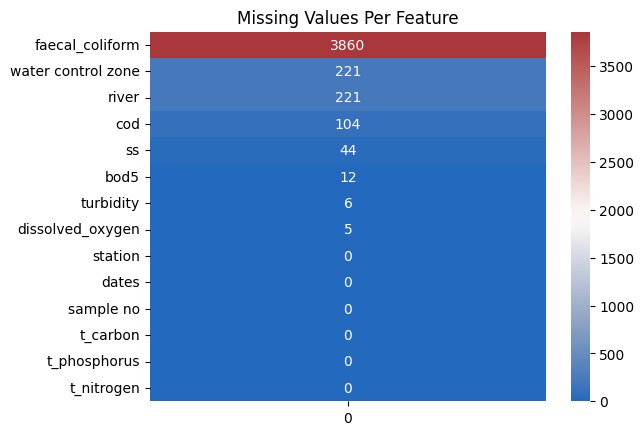

In [13]:
plt.title('Missing Values Per Feature')
nans = new_df.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

In [14]:
# Remplacer les cases vides dans les colonnes ZONE et River en utilisant la valeur de la colonne Station
new_df['water control zone'] = new_df.apply(lambda x: x['station'] if pd.isna(x['water control zone']) else x['water control zone'], axis=1)
new_df['river'] = new_df.apply(lambda x: x['station'] if pd.isna(x['river']) else x['river'], axis=1)

In [15]:
new_df.dtypes

water control zone     object
river                  object
station                object
dates                  object
sample no               int64
turbidity             float64
ss                    float64
dissolved_oxygen      float64
bod5                  float64
cod                   float64
t_carbon              float64
t_phosphorus          float64
t_nitrogen            float64
faecal_coliform       float64
dtype: object

In [16]:
# remplacer les valeurs manquantes de chaque colonne par la moyenne de cette colonne pour toutes les lignes qui ont le même état
df_clean = new_df.fillna(new_df.groupby('station').transform('mean'))

<ipython-input-16-9aed19e0d5f9>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_clean = new_df.fillna(new_df.groupby('station').transform('mean'))


In [17]:
df_clean.shape

(4958, 14)

<ipython-input-18-48f18f16c42b>:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col_index.name)


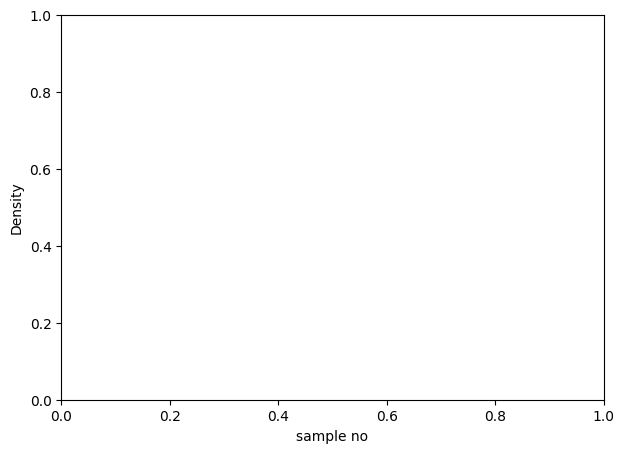

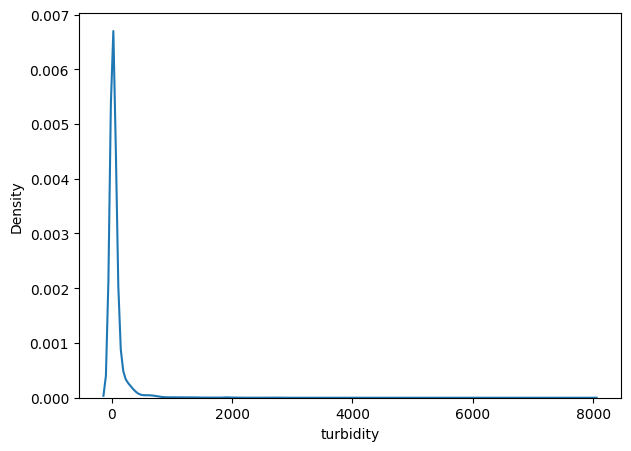

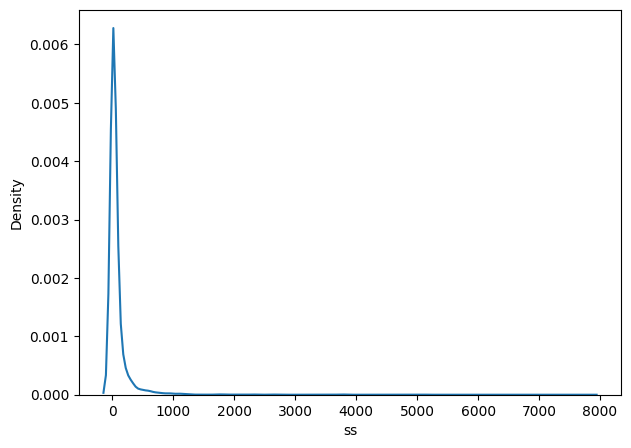

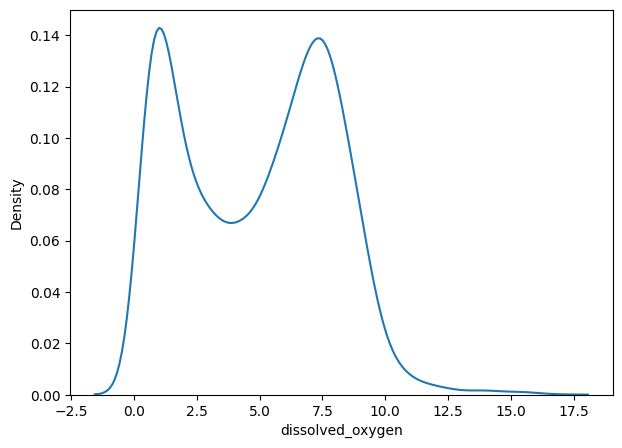

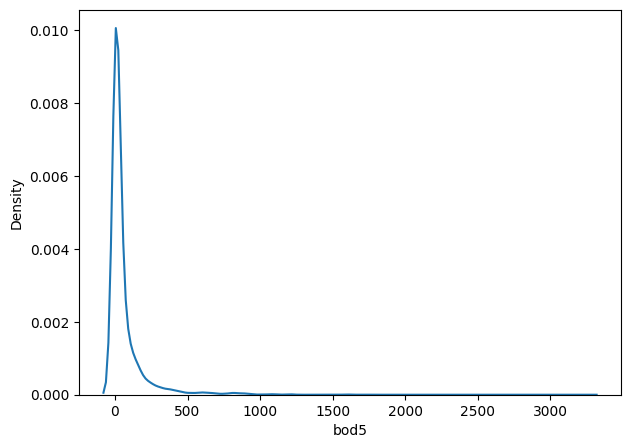

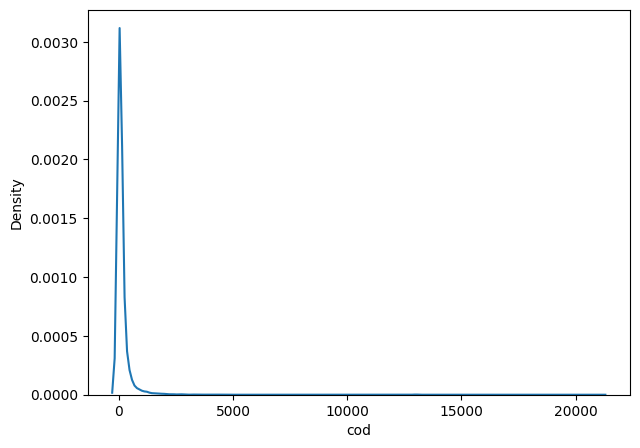

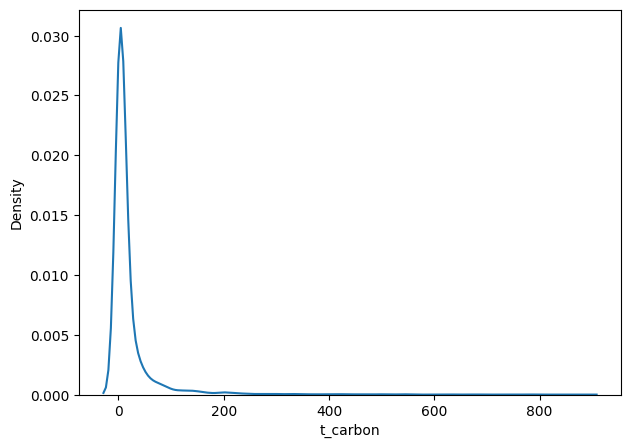

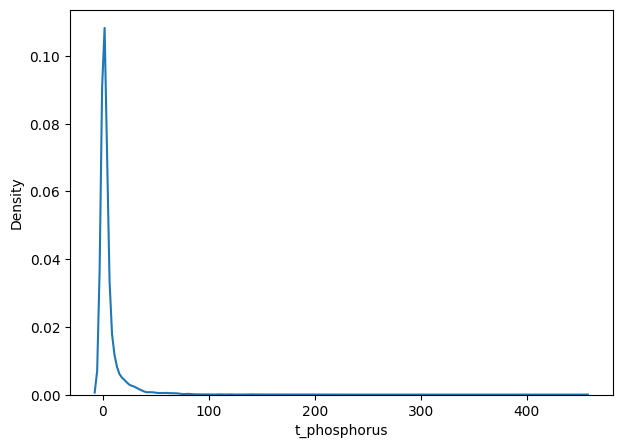

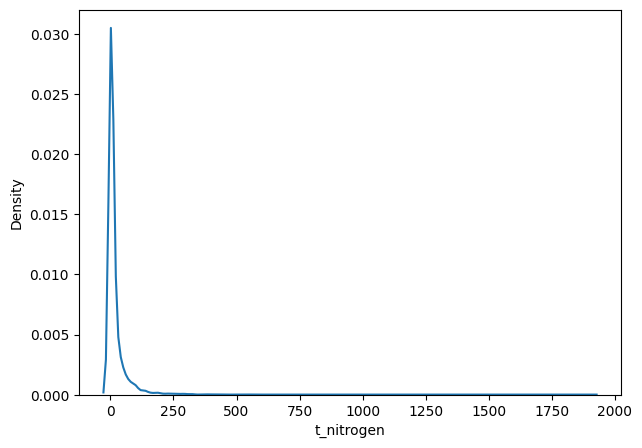

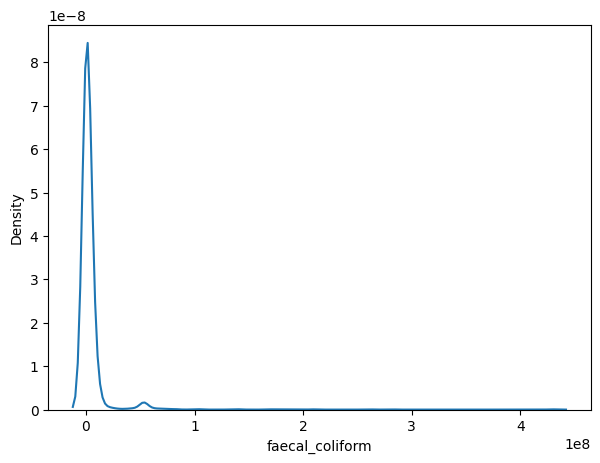

In [18]:
#Tracer PDFs de tous les attributs numériques de l’ensemble de données

df_num_final = df_clean.select_dtypes(exclude="object")

def plot_kde(df):
    n_col = df.shape[1]
    for index in range(n_col):
        col_index = df.iloc[:, index]
        fig, ax = plt.subplots(1,1, figsize=(7, 5))
        sns.kdeplot(data=df, x=col_index.name)
        
plot_kde(df_num_final)

In [19]:
# Ici, presque tous les plots kde sont gaussiens 
# Utilisation de la normalisation Z-Score pour détecter les valeurs aberrantes

df_num_final_norm = df_num_final.apply(zscore, axis=0)

def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[:, index]
        greater_than_3 = col_index[col_index > 3]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_num_final_norm)
print("Number of outliers using Z-Score method: ", len(indices_arr))
df_clean.iloc[indices_arr, :]

Number of outliers using Z-Score method:  516


,water control zone,river,station,dates,sample no,turbidity,ss,dissolved_oxygen,bod5,cod,t_carbon,t_phosphorus,t_nitrogen,faecal_coliform
129,North Western,Tuen Mun River,TN1,4/14/1986,1,1880.0,3800.0,0.3,1089.0,13000.0,520.0,450.0,1900.0,53262700.0
136,North Western,Tuen Mun River,TN1,11/11/1986,1,1200.0,320.0,1.3,483.0,480.0,680.0,20.0,110.0,53262700.0
476,Deep Bay,Yuen Long Creek,YL1,3/12/1986,1,910.0,820.0,0.3,1070.0,4400.0,780.0,300.0,880.0,NaN
570,Junk Bay,Tseng Lan Shue Stream,JR3,2/16/1987,1,2000.0,3800.0,0.6,3240.0,7300.0,30.0,180.0,560.0,NaN
900,Tolo Harbour And Channel,Tai Wai Nullah,TR19,10/26/1987,1,1003.0,100.0,5.9,29.1,99.0,19.0,5.2,13.0,767820.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4113,Deep Bay,Yuen Long Creek,YL1,3/5/1991,1,660.0,1000.0,0.7,1600.0,1900.0,190.0,90.0,320.0,NaN
4114,Deep Bay,Yuen Long Creek,YL1,4/3/1991,1,600.0,650.0,0.8,1100.0,1200.0,53.0,94.9,190.0,NaN
4115,Deep Bay,Yuen Long Creek,YL1,5/1/1991,1,500.0,810.0,0.7,1200.0,1400.0,220.0,110.0,220.0,NaN
4116,Deep Bay,Yuen Long Creek,YL1,6/3/1991,1,270.0,1200.0,2.5,1500.0,1500.0,380.0,120.0,270.0,NaN


In [20]:
df_clean.drop(indices_arr, axis=0, inplace=True)
df_clean.shape

(4696, 14)

In [21]:
df_clean=df_clean.dropna()

<Axes: title={'center': 'Missing Values Per Feature'}>

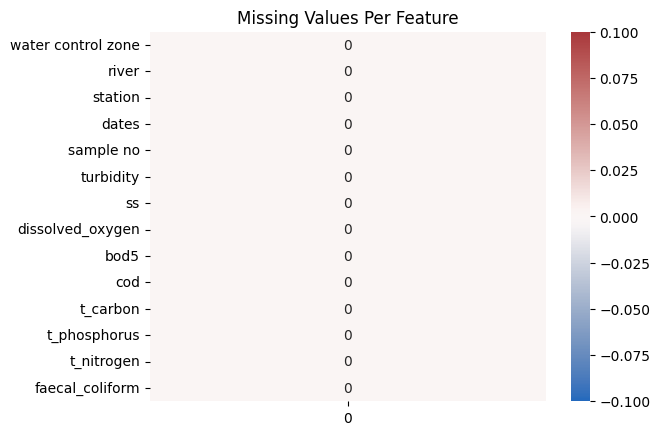

In [22]:
plt.title('Missing Values Per Feature')
nans = df_clean.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

In [23]:
import pandas as pd
import numpy as np

# Créer la fonction de sous-index pour turbidité
def turbidity_si(turbidity):
    if turbidity <= 1.5:
        return 10
    elif 1.5 < turbidity <= 3.0:
        return 20
    elif 3.0 < turbidity <= 4.0:
        return 30
    elif 4.0 < turbidity <= 4.5:
        return 40
    elif 4.5 < turbidity <= 5.2:
        return 50
    elif 5.2 < turbidity <= 8.8:
        return 60
    elif 8.8 < turbidity <= 12.2:
        return 70
    elif 12.2 < turbidity <= 16.5:
        return 80
    elif 16.5 < turbidity <= 21:
        return 90
    else:
        return 100

# Créer la fonction de sous-index pour la matière en suspension
def ss_si(ss):
    if ss <= 2:
        return 10
    elif 2 < ss <= 3:
        return 20
    elif 3 < ss <= 4:
        return 30
    elif 4 < ss <= 5.5:
        return 40
    elif 5.5 < ss <= 6.5:
        return 50
    elif 6.5 < ss <= 9.5:
        return 60
    elif 9.5 < ss <= 12.5:
        return 70
    elif 12.5 < ss <= 18:
        return 80
    elif 18 < ss <= 26.5:
        return 90
    else:
        return 100

# Créer la fonction de sous-index pour l'oxygène dissous
def dissolved_oxygen_si(dissolved_oxygen):
    if dissolved_oxygen >= 8:
        return 10
    elif 7.3 <= dissolved_oxygen < 8:
        return 20
    elif 6.7 <= dissolved_oxygen < 7.3:
        return 30
    elif 6.3 <= dissolved_oxygen < 6.7:
        return 40
    elif 5.8 <= dissolved_oxygen < 6.3:
        return 50
    elif 5.3 <= dissolved_oxygen < 5.8:
        return 60
    elif 4.8 <= dissolved_oxygen < 5.3:
        return 70
    elif 4 <= dissolved_oxygen < 4.8:
        return 80
    elif 3.1 <= dissolved_oxygen < 4:
        return 90
    else:
        return 100
# Créer la fonction de sous-index pour bod5
def bod5_si(bod5):
    if bod5 <= 0.8:
        return 10
    elif 0.8 <= bod5 < 1:
        return 20
    elif 1 <= bod5 < 1.1:
        return 30
    elif 1.1 <= bod5 < 1.3:
        return 40
    elif 1.3 <= bod5 < 1.5:
        return 50
    elif 1.5 <= bod5 < 1.9:
        return 60
    elif 1.9 <= bod5 < 2.3:
        return 70
    elif 2.3 <= bod5 < 3.3:
        return 80
    elif 3.3 <= bod5 < 5.1:
        return 90
    else:
        return 100

# Créer la fonction de sous-index pour cod
def cod_si(cod):
    if cod <= 16:
        return 10
    elif 16 <= cod < 24:
        return 20
    elif 24 <= cod < 32:
        return 30
    elif 32 <= cod < 38:
        return 40
    elif 38 <= cod < 46:
        return 50
    elif 46 <= cod < 58:
        return 60
    elif 58 <= cod < 72:
        return 70
    elif 72 <= cod < 102:
        return 80
    elif 102 <= cod < 146:
        return 90
    else:
        return 100


# Créer la fonction de sous-index pour t_carbon
def t_carbon_si(t_carbon):
    if t_carbon <= 5:
        return 10
    elif 5 <= t_carbon < 7:
        return 20
    elif 7 <= t_carbon < 9.5:
        return 30
    elif 9.5 <= t_carbon < 12:
        return 40
    elif 12 <= t_carbon < 14:
        return 50
    elif 14 <= t_carbon < 17.5:
        return 60
    elif 17.5 <= t_carbon < 21:
        return 70
    elif 21 <= t_carbon < 27.5:
        return 80
    elif 27.5 <= t_carbon < 37:
        return 90
    else:
        return 100

# Créer la fonction de sous-index pour t_carbon
def t_nitrogen_si(t_nitrogen):
    if t_nitrogen <= 0.55:
        return 10
    elif 0.55 <= t_nitrogen < 0.75:
        return 20
    elif 0.75 <= t_nitrogen < 0.9:
        return 30
    elif 0.9 <= t_nitrogen < 1:
        return 40
    elif 1 <= t_nitrogen < 1.2:
        return 50
    elif 1.2 <= t_nitrogen < 1.4:
        return 60
    elif 1.4 <= t_nitrogen < 1.6:
        return 70
    elif 1.6 <= t_nitrogen < 2:
        return 80
    elif 2 <= t_nitrogen < 2.7:
        return 90
    else:
        return 100

# Créer la fonction de sous-index pour t_phosphorus
def t_phosphorus_si(t_phosphorus):
    if t_phosphorus <= 0.02:
        return 10
    elif 0.02 <= t_phosphorus < 0.03:
        return 20
    elif 0.03 <= t_phosphorus < 0.05:
        return 30
    elif 0.05 <= t_phosphorus < 0.07:
        return 40
    elif 0.07 <= t_phosphorus < 0.09:
        return 50
    elif 0.09 <= t_phosphorus < 0.16:
        return 60
    elif 0.16 <= t_phosphorus < 0.24:
        return 70
    elif 0.24 <= t_phosphorus < 0.46:
        return 80
    elif 0.46 <= t_phosphorus < 0.89:
        return 90
    else:
        return 100

# Créer la fonction de sous-index pour faecal_coliform
def faecal_coliform_si(faecal_coliform):
    if faecal_coliform <= 10:
        return 10
    elif 10 <= faecal_coliform < 20:
        return 20
    elif 20 <= faecal_coliform < 35:
        return 30
    elif 35 <= faecal_coliform < 55:
        return 40
    elif 55 <= faecal_coliform < 75:
        return 50
    elif 75 <= faecal_coliform < 135:
        return 60
    elif 135 <= faecal_coliform < 190:
        return 70
    elif 190 <= faecal_coliform < 470:
        return 80
    elif 470 <= faecal_coliform < 960:
        return 90
    elif faecal_coliform > 960:
        return 100
    elif faecal_coliform == None:
        return 50

In [24]:
# Appliquer les fonctions de sous-index aux colonnes correspondantes dans le dataframe
df_clean['turbidity_si'] = df_clean['turbidity'].apply(turbidity_si)
df_clean['ss_si'] = df_clean['ss'].apply(ss_si)
df_clean['dissolved_oxygen_si'] = df_clean['dissolved_oxygen'].apply(dissolved_oxygen_si)

df_clean['bod5_si'] = df_clean['bod5'].apply(bod5_si)
df_clean['cod_si'] = df_clean['cod'].apply(cod_si)
df_clean['t_carbon_si'] = df_clean['t_carbon'].apply(t_carbon_si)

df_clean['t_nitrogen_si'] = df_clean['t_nitrogen'].apply(t_nitrogen_si)
df_clean['t_phosphorus_si'] = df_clean['t_phosphorus'].apply(t_phosphorus_si)
df_clean['faecal_coliform_si'] = df_clean['faecal_coliform'].apply(faecal_coliform_si)

In [25]:
# Calcul du WQI
df_clean['wqi'] = np.round(df_clean[['turbidity_si', 'ss_si', 'dissolved_oxygen_si', 'bod5_si', 'cod_si', 't_carbon_si', 't_nitrogen_si', 't_phosphorus_si', 'faecal_coliform_si']].mean(axis=1, skipna=True))

In [26]:
df_clean["wqi clf"] = df_clean["wqi"].apply(lambda x: (4 if (0 <=x <= 25)
                                        else(3 if (26<=x<=50)
                                        else(2 if (51<=x<=75)
                                        else(1 if (76<=x<=100)
                                        else 0)))))

In [27]:
df_clean.tail(1)

,water control zone,river,station,dates,sample no,turbidity,ss,dissolved_oxygen,bod5,cod,...,ss_si,dissolved_oxygen_si,bod5_si,cod_si,t_carbon_si,t_nitrogen_si,t_phosphorus_si,faecal_coliform_si,wqi,wqi clf
4922,Tolo Harbour And Channel,Siu Lek Yuen Nullah,TR23A,12/14/1992,1,7.6,2.5,3.0,12.0,180.0,...,20,100,100,100,10,90,90,100,74.0,2


In [28]:
n_unsuitable=(df_clean['wqi clf']==0).sum()
n_very_poor=(df_clean['wqi clf']==1).sum()
n_poor=(df_clean['wqi clf']==2).sum()
n_good=(df_clean['wqi clf']==3).sum()
n_excellent=(df_clean['wqi clf']==4).sum()

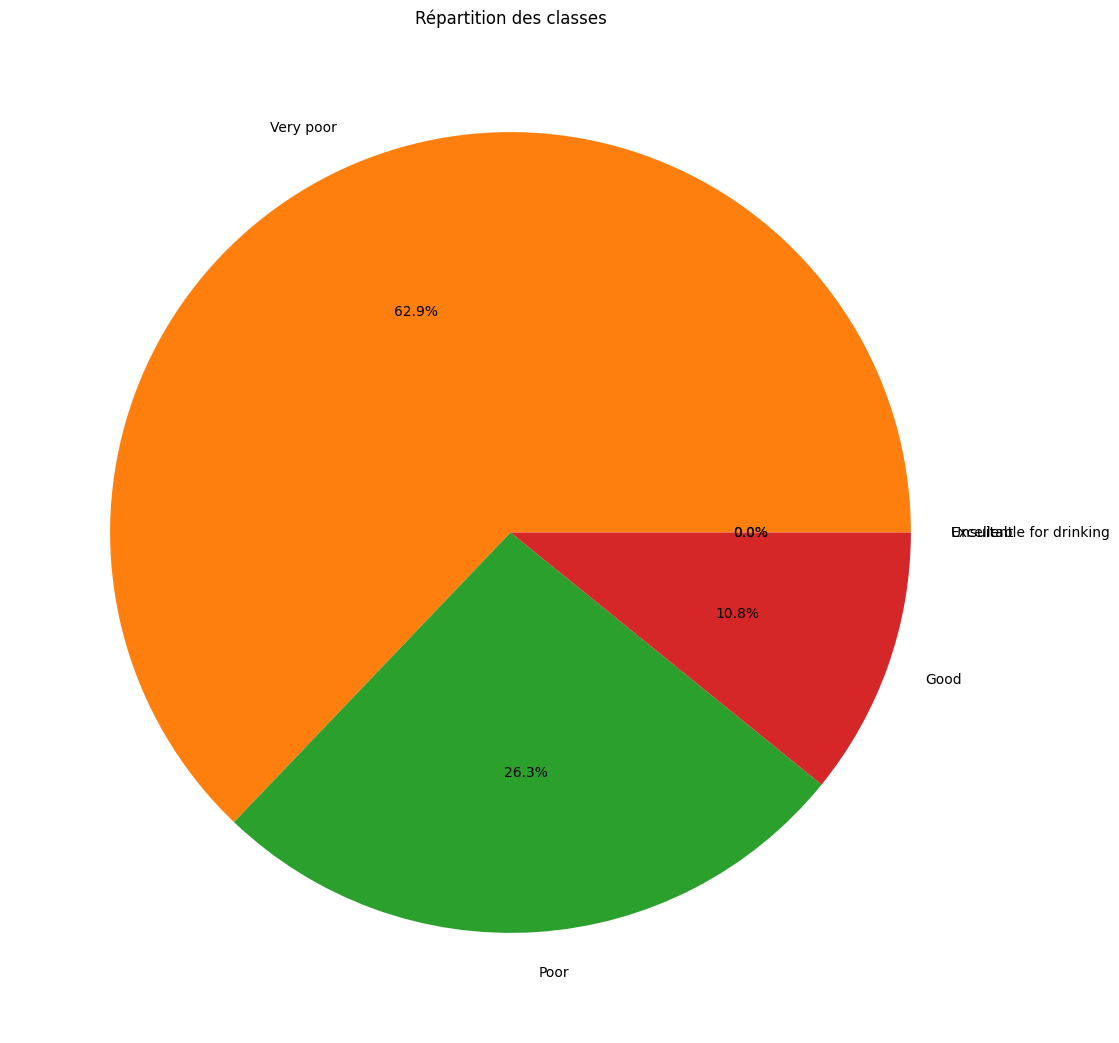

In [29]:
import matplotlib.pyplot as plt
# Définition des classes et de leurs effectifs
classes = ['Unsuitable for drinking', 'Very poor', 'Poor', 'Good', 'Excellent']
effectifs = [n_unsuitable,n_very_poor,n_poor,n_good,n_excellent]
# Création du diagramme circulaire
fig, ax = plt.subplots()
ax.pie(effectifs, labels=classes, autopct='%2.1f%%')
# Définir la taille de la figure
fig.set_size_inches(14, 13)
# Ajout d'un titre
ax.set_title('Répartition des classes')
# Affichage du diagramme
plt.show()

In [ ]:
df_wqi=df_clean[['water control zone','river','station','dates','sample no','turbidity',
         'ss', 'dissolved_oxygen','bod5','cod','t_carbon','t_phosphorus','t_nitrogen','faecal_coliform','wqi','wqi clf']]

In [30]:
import pandas as pd
# Enregistrement en format CSV sans index
df_wqi.to_csv('Water_dataX_mean_state_hong_kong.csv', index=False)

NameError: ignored

In [31]:
df=pd.read_csv('Water_dataX_mean_state_hong_kong.csv')

In [32]:
B=set()
j=1
for i in df['water control zone']:
    B.add(i)
for k in B:
  j+=1
print(j)
print(B)

11
{'Victoria Harbour', 'Southern', 'DB7', 'Junk Bay', 'DB4', 'Western Buffer', 'Deep Bay', 'Port Shelter', 'Tolo Harbour And Channel', 'North Western'}


In [33]:
B=set()
j=1
for i in df['river']:
    B.add(i)
for k in B:
  j+=1
print(j)
print(B)

37
{'Yuen Long Creek', 'Ngau Hom Sha Stream', 'Tseng Lan Shue Stream', 'Sha Kok Mei Stream', 'Tai Po Kau Stream', 'Ha Pak Nai Stream', 'Shan Liu Stream', 'Tuen Mun River', 'Tai Shui Hang Stream', 'Sam Dip Tam Stream', 'Tin Sum Nullah', 'Kau Wa Keng Stream', 'DB4', 'Sheung Pak Nai Stream', 'Shing Mun River', 'DB7', 'Kam Tin River', 'Ho Chung River', 'Tsang Kok Stream', 'Fairview Park Nullah', 'Siu Lek Yuen Nullah', 'Tai Po River', 'River Indus', 'Tung Chung River', 'Pak Nai Stream', 'Tin Shui Wai Nullah', 'Kai Tak River', 'Tai Wai Nullah', 'Mui Wo River', 'River Beas', 'Pai Min Kok Stream', 'Tung Tze Stream', 'Kwun Yam Shan Stream', 'River Ganges', 'Tai Chung Hau Stream', 'Lam Tsuen River'}


In [34]:
B=set()
j=1
for i in df['station']:
    B.add(i)
for k in B:
  j+=1
print(j)
print(B)

85
{'AN2', 'KT1', 'TN6', 'TR14', 'MW5', 'IN2', 'MW1', 'GR3', 'TR12H', 'YL1', 'PR7', 'AN1', 'RB1', 'TR12I', 'JR3', 'TR12E', 'KN4', 'TR17', 'TN4', 'TN5', 'TSR2', 'KW3', 'TN1', 'TW1', 'TR12C', 'DB8', 'PR2', 'GR2', 'TR4', 'TW3', 'DB7', 'TR19I', 'TSR1', 'TR23A', 'GR1', 'FVR1', 'DB5', 'TN2', 'DB2', 'MW3', 'KN5', 'TR12G', 'YL3', 'TR13', 'RB2', 'PR6', 'KN2', 'RB3', 'TR12D', 'TR19', 'TW2', 'DB1', 'TC1', 'TN3', 'KT2', 'KN7', 'JR11', 'PR5', 'TR17L', 'DB3', 'TC3', 'YL4', 'KN1', 'PR1', 'KN3', 'TR19C', 'KY1', 'JR6', 'YL2', 'PR8', 'DB6', 'MW4', 'DB4', 'TC2', 'TR23L', 'IN1', 'TR12B', 'TR20B', 'TR12F', 'MW2', 'TR12', 'TR19A', 'IN3', 'TR6'}


In [35]:
df=df[['turbidity','ss', 'dissolved_oxygen','bod5','cod','t_carbon','t_phosphorus','t_nitrogen','faecal_coliform','wqi clf']]

In [36]:
# Charger les données
data = df

In [37]:
cols_to_drop=["wqi clf"]
# Diviser les données en caractéristiques et cibles
X =  data.drop(cols_to_drop, axis=1)
y = data["wqi clf"].values

In [38]:
# Encoder les labels catégoriels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [39]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Balancing the data by SMOTE - Oversampling of Minority level\n')
smt = SMOTE()
counter = Counter(y)
print('Before SMOTE', counter)
X,y = smt.fit_resample(X,y)
counter = Counter(y)
print('\nAfter SMOTE', counter)

Balancing the data by SMOTE - Oversampling of Minority level

Before SMOTE Counter({2: 14139, 1: 9063, 0: 5208, 3: 2118})

After SMOTE Counter({1: 14139, 0: 14139, 2: 14139, 3: 14139})


In [40]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Redimensionner les données pour les convolutions 1D
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

In [44]:
# Convertir les labels en one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Créer le modèle CNN
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation="softmax"))

# Compiler le modèle
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [45]:
# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=250, batch_size=32)
print(history.history['accuracy'])
print(history.history['loss'])

Epoch 1/250
1414/1414 [==============================] - 9s 5ms/step - loss: 0.3826 - accuracy: 0.8455 - val_loss: 0.2817 - val_accuracy: 0.8928
Epoch 2/250
1414/1414 [==============================] - 7s 5ms/step - loss: 0.2471 - accuracy: 0.9036 - val_loss: 0.2258 - val_accuracy: 0.9043
Epoch 3/250
1414/1414 [==============================] - 7s 5ms/step - loss: 0.2186 - accuracy: 0.9144 - val_loss: 0.2099 - val_accuracy: 0.9152
Epoch 4/250
1414/1414 [==============================] - 7s 5ms/step - loss: 0.1993 - accuracy: 0.9231 - val_loss: 0.1887 - val_accuracy: 0.9273
Epoch 5/250
1414/1414 [==============================] - 7s 5ms/step - loss: 0.2064 - accuracy: 0.9201 - val_loss: 0.2110 - val_accuracy: 0.9096
Epoch 6/250
1414/1414 [==============================] - 7s 5ms/step - loss: 0.1933 - accuracy: 0.9245 - val_loss: 0.1511 - val_accuracy: 0.9395
Epoch 7/250
1414/1414 [==============================] - 9s 6ms/step - loss: 0.1900 - accuracy: 0.9254 - val_loss: 0.3800 - val_ac

KeyboardInterrupt: ignored

In [ ]:
# Évaluer le modèle sur les données de test
score = model.evaluate(X_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

354/354 [==============================] - 0s 1ms/step - loss: 0.1154 - accuracy: 0.9708
Test loss: 0.11540529876947403
Test accuracy: 0.9708274602890015


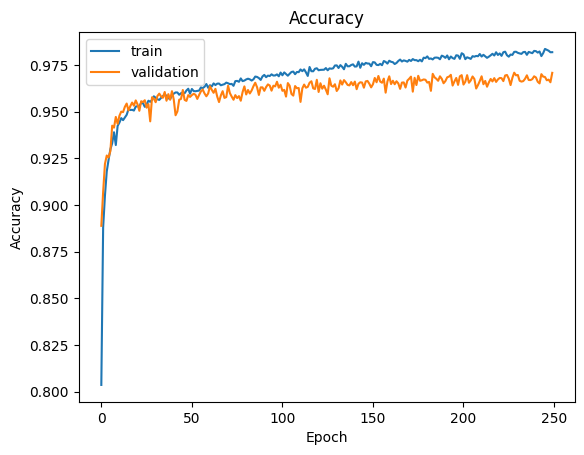

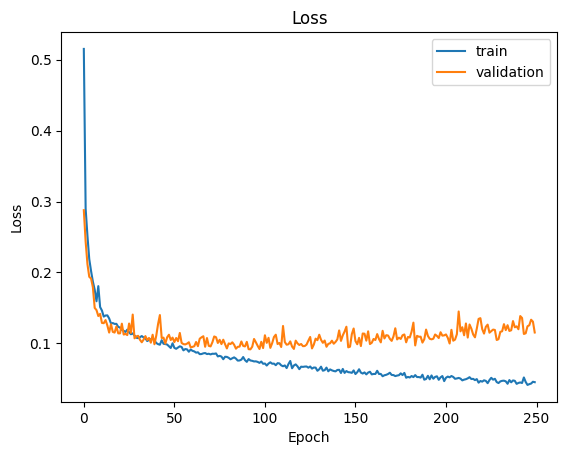

In [ ]:
# Afficher les graphes d'accuracy et loss selon l'epoch
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
model.save('classification_model_5_hong_kong.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Charger le modèle CNN entraîné
model = load_model('classification_model_5_hong_kong.h5')

In [ ]:
y_pred = model.predict(X_test,batch_size=150, verbose=0)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

In [ ]:
cm = confusion_matrix(y_true,y_pred)

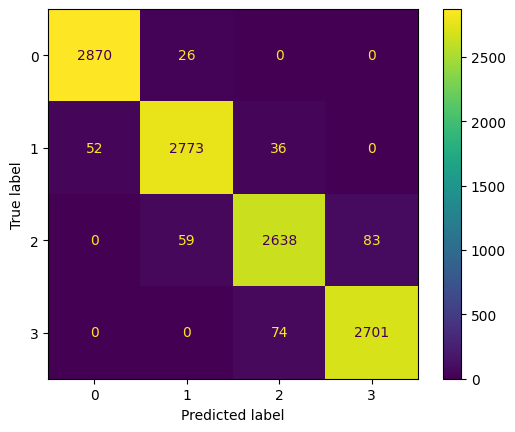

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
print ("Classification Report")
print(classification_report(y_true,y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2896
           1       0.97      0.97      0.97      2861
           2       0.96      0.95      0.95      2780
           3       0.97      0.97      0.97      2775

    accuracy                           0.97     11312
   macro avg       0.97      0.97      0.97     11312
weighted avg       0.97      0.97      0.97     11312



# **FORCASTION WITH ARIMA**

choisis votre zone
{'DB7', 'North Western', 'Southern', 'Deep Bay', 'DB4', 'Western Buffer', 'Port Shelter', 'Tolo Harbour And Channel', 'Victoria Harbour', 'Junk Bay'}
Junk Bay
choisis votre rivier
{'Tseng Lan Shue Stream'}
Tseng Lan Shue Stream
choisis votre station
{'JR3', 'JR6', 'JR11'}
JR11


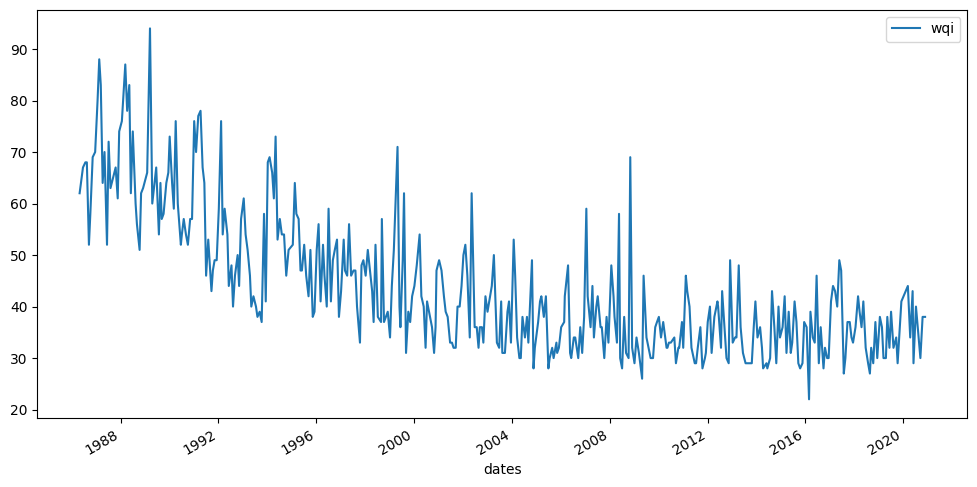

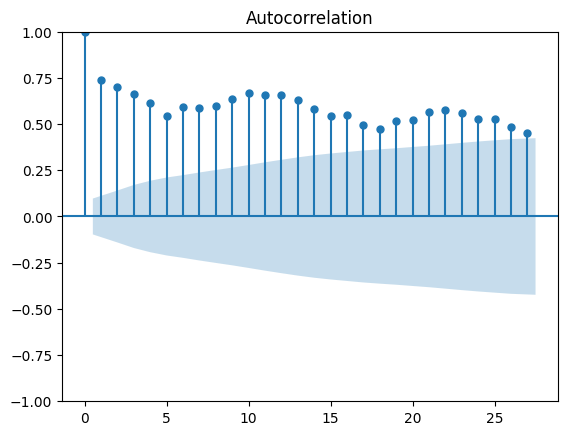

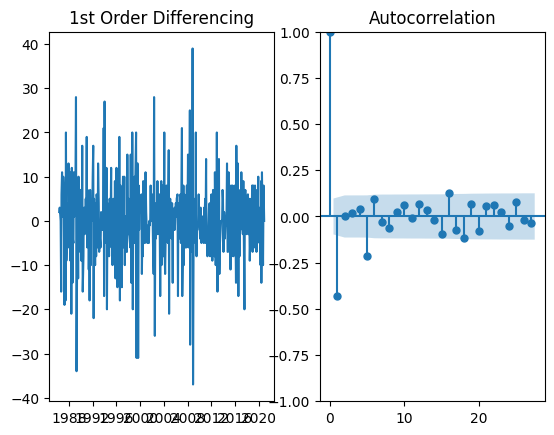

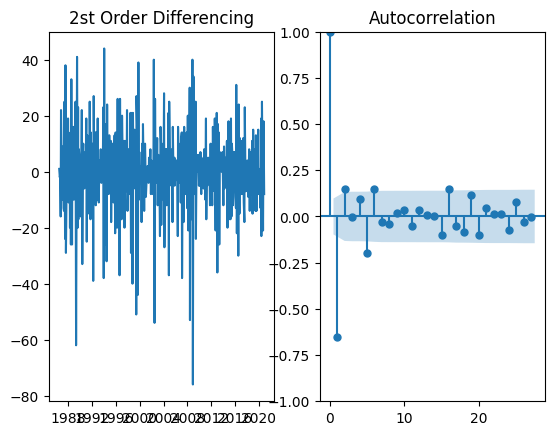

p-value:  0.0967165677301573
p-value:  3.435625826322454e-24
p-value:  9.105308436032888e-25


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.

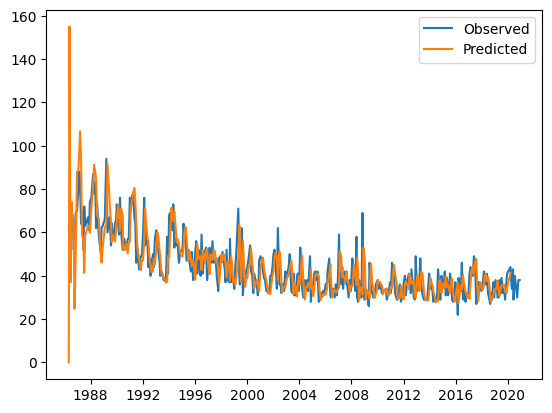

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Forecasted WQI values for 2021, 2022, 2023 and 2020:


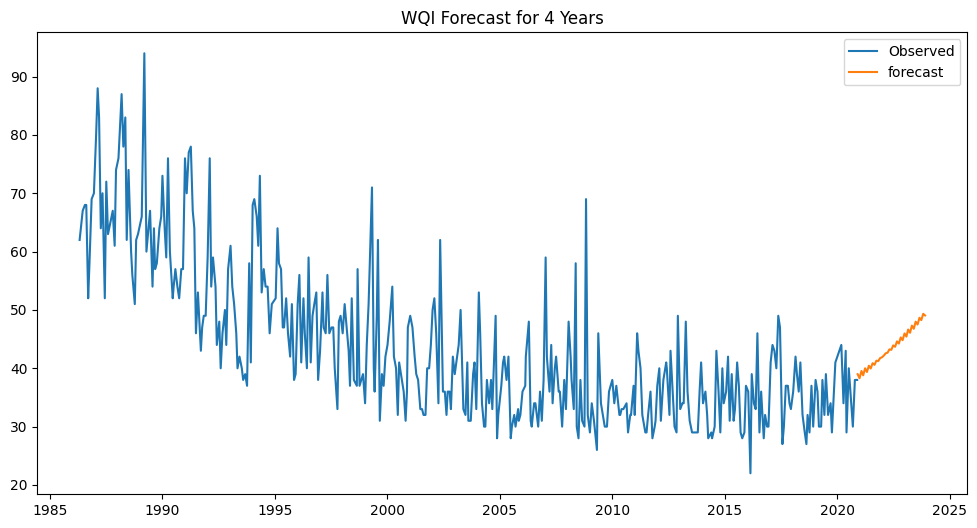

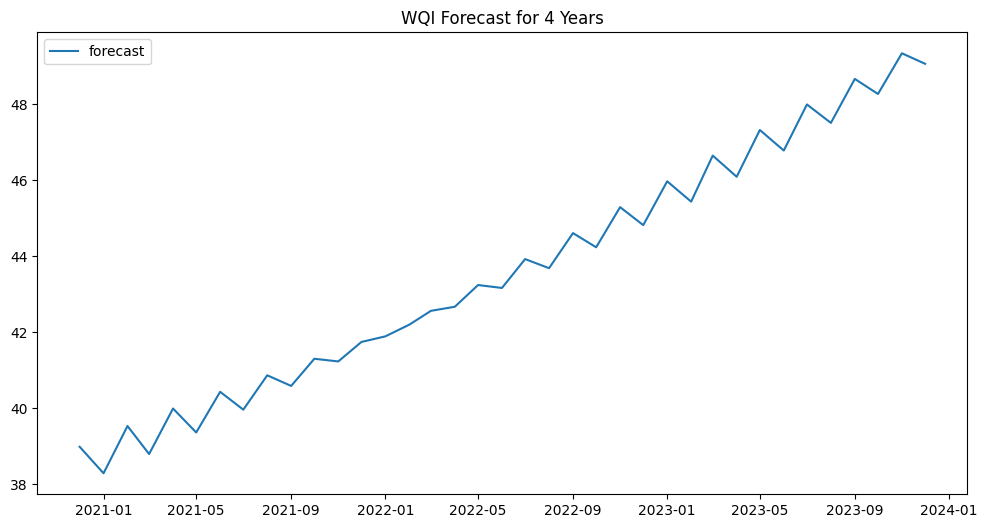

In [168]:
df=pd.read_csv('Water_dataX_mean_state_hong_kong.csv')
df=df[['water control zone','river','station','dates','wqi']]
print('choisis votre zone')
B=set()
for i in df['water control zone']:
    B.add(i)
print(B)
zone=input()
print('choisis votre rivier')
C=set()
for i in df[df['water control zone']==zone]['river']:
    C.add(i)
print(C)
river=input()
print('choisis votre station')
D=set()
for i in df[df['river']==river]['station']:
    D.add(i)
print(D)
station=input()

data = df[['dates', 'wqi']][(df['water control zone'] ==zone) & (df['river'] == river) & (df['station'] == station)]
data.to_csv('data1.csv',index=False)
df = pd.read_csv('data1.csv',index_col='dates',parse_dates=True)
df.plot(figsize=(12,6))
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

# Load the data into a pandas DataFrame called df

# Plot the autocorrelation function of the WQI time series
plot_acf(df['wqi'])

# Perform first-order differencing on the time series and plot the differenced time series and its autocorrelation function
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(df['wqi'].diff())
ax2 = f.add_subplot(122)
plot_acf(df['wqi'].diff().dropna(), ax=ax2)
plt.show()

# Perform second-order differencing on the time series and plot the differenced time series and its autocorrelation function
ff = plt.figure()
ax1_1 = ff.add_subplot(121)
ax1_1.set_title('2st Order Differencing')
ax1_1.plot(df['wqi'].diff().diff())
ax2_2 = ff.add_subplot(122)
plot_acf(df['wqi'].diff().diff().dropna(), ax=ax2_2)
plt.show()

# Perform the Augmented Dickey-Fuller (ADF) test to check the stationarity of the time series at different levels of differencing
result = adfuller(df['wqi'].dropna())
print('p-value: ',result[1])

result = adfuller(df['wqi'].diff().dropna())
print('p-value: ',result[1])

result = adfuller(df['wqi'].diff().diff().dropna())
print('p-value: ',result[1])

# Create an ARIMA model with order (1, 3, 2)
arima_model = sm.tsa.arima.ARIMA(df['wqi'], order=(3, 4, 5))

# Fit the ARIMA model
model = arima_model.fit()

# Generate predictions for the entire time period from 1986 to 2023
predictions = model.predict(start='1986', end='2020')

# Plot the observed and predicted values together
plt.plot(df['wqi'], label='Observed')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


# Generate forecasts for the new years 2021, 2022, and 2023,2024
import pandas as pd

start_date = pd.to_datetime('2020-11-23')
end_date = pd.to_datetime('2023-12-09')
forecast_index = pd.date_range(start=start_date, end=end_date, freq='MS')
forecast = model.forecast(steps=len(forecast_index))
forecast.index = forecast_index

# Print the forecasted WQI values
print('Forecasted WQI values for 2021, 2022, 2023 and 2020:')
plt.figure(figsize=(12,6))
plt.plot(df['wqi'], label='Observed')
plt.plot(forecast.index, forecast, label='forecast')
plt.title('WQI Forecast for 4 Years')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(forecast.index, forecast, label='forecast')
plt.title('WQI Forecast for 4 Years')
plt.legend()
plt.show()


# **ARIMA FOR FORCASTING**

In [1]:
import pandas as pd

choisis votre zone
{'DB7', 'Western Buffer', 'Deep Bay', 'Southern', 'North Western', 'Junk Bay', 'Victoria Harbour', 'Port Shelter', 'DB4', 'Tolo Harbour And Channel'}
Junk Bay
choisis votre rivier
{'Tseng Lan Shue Stream'}
Tseng Lan Shue Stream
choisis votre station
{'JR11', 'JR3', 'JR6'}
JR11


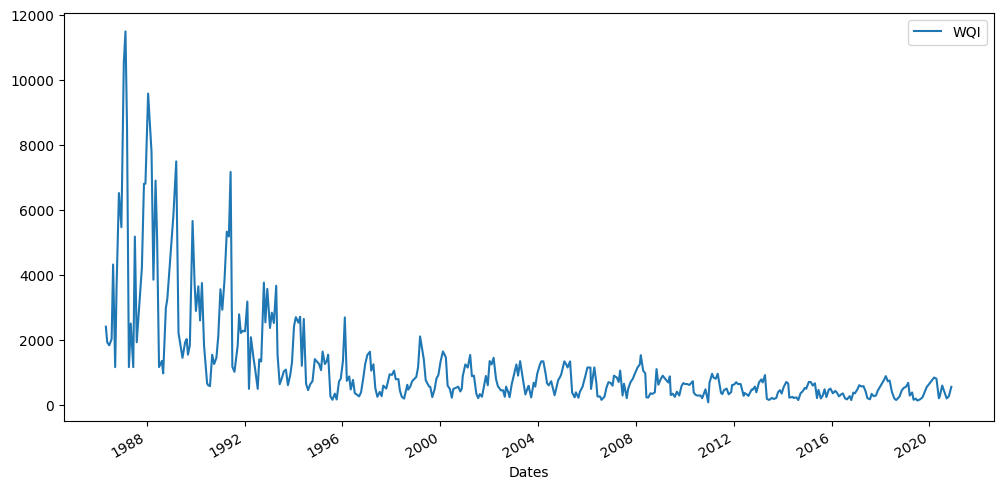

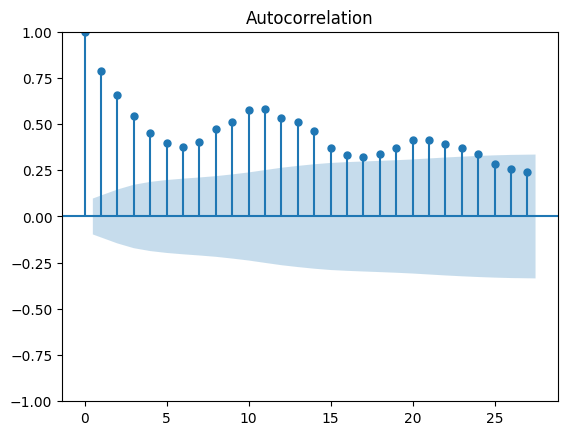

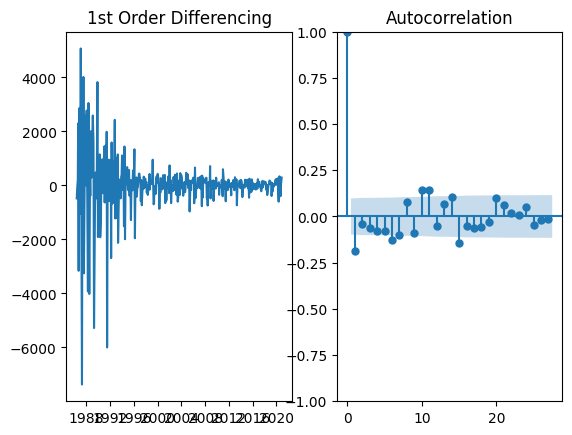

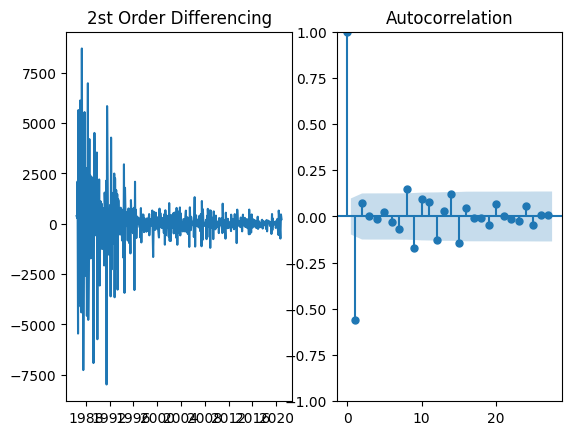

p-value:  0.0002709662330316768
p-value:  1.8031139219406647e-13
p-value:  2.0156196998261926e-16


In [5]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

# Load the data into a pandas DataFrame called df
df=pd.read_csv('Water_dataX_mean_state_hong_kong.csv')
df=df[['ZONE','River','Station','Dates','WQI']]
print('choisis votre zone')
B=set()
for i in df['ZONE']:
    B.add(i)
print(B)
zone=input()
print('choisis votre rivier')
C=set()
for i in df[df['ZONE']==zone]['River']:
    C.add(i)
print(C)
river=input()
print('choisis votre station')
D=set()
for i in df[df['River']==river]['Station']:
    D.add(i)
print(D)
station=input()

data = df[['Dates', 'WQI']][(df['ZONE'] ==zone) & (df['River'] == river) & (df['Station'] == station)]
data.to_csv('data1.csv',index=False)
df = pd.read_csv('data1.csv',index_col='Dates',parse_dates=True)
df.plot(figsize=(12,6))
# Plot the autocorrelation function of the WQI time series
plot_acf(df['WQI'])

# Perform first-order differencing on the time series and plot the differenced time series and its autocorrelation function
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(df['WQI'].diff())
ax2 = f.add_subplot(122)
plot_acf(df['WQI'].diff().dropna(), ax=ax2)
plt.show()

# Perform second-order differencing on the time series and plot the differenced time series and its autocorrelation function
ff = plt.figure()
ax1_1 = ff.add_subplot(121)
ax1_1.set_title('2st Order Differencing')
ax1_1.plot(df['WQI'].diff().diff())
ax2_2 = ff.add_subplot(122)
plot_acf(df['WQI'].diff().diff().dropna(), ax=ax2_2)
plt.show()

# Perform the Augmented Dickey-Fuller (ADF) test to check the stationarity of the time series at different levels of differencing
result = adfuller(df['WQI'].dropna())
print('p-value: ',result[1])

result = adfuller(df['WQI'].diff().dropna())
print('p-value: ',result[1])

result = adfuller(df['WQI'].diff().diff().dropna())
print('p-value: ',result[1])

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


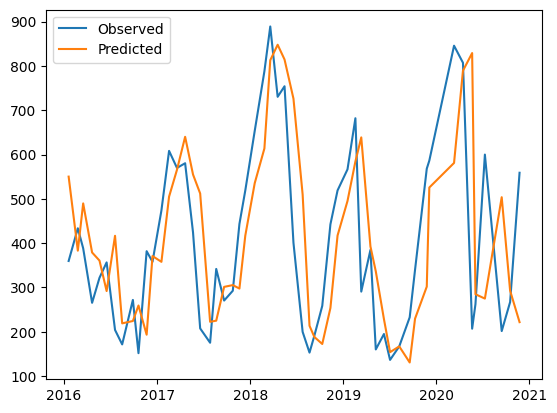

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Forecasted WQI values for 2021, 2022, 2023 and 2020:


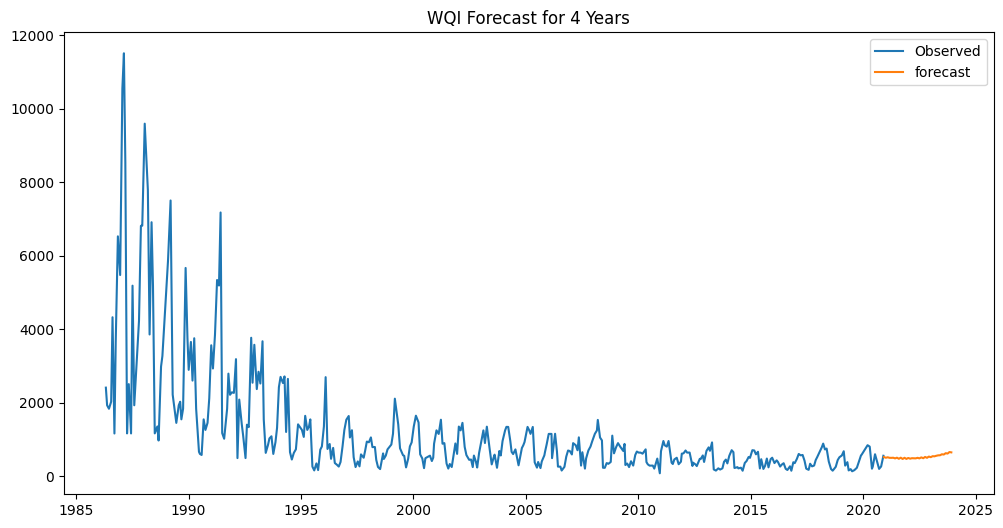

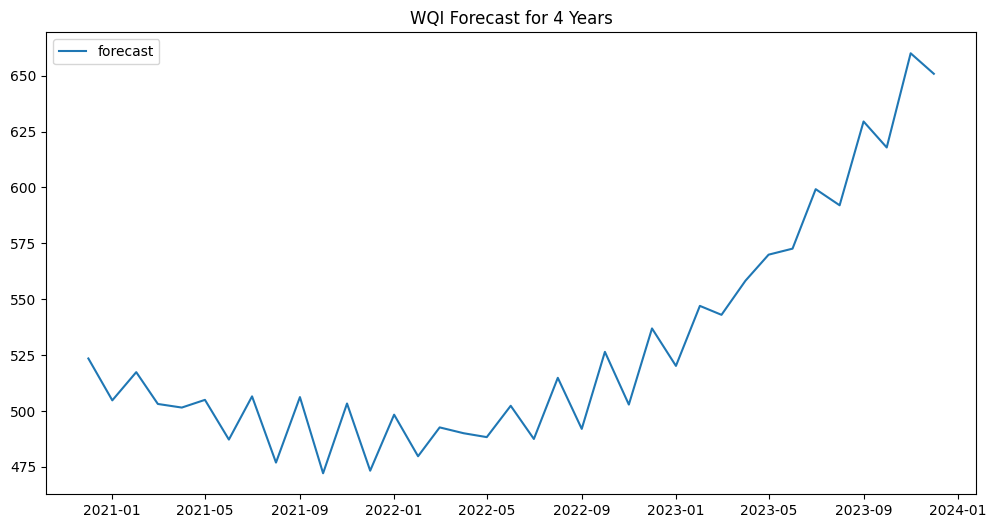

In [12]:
# Create an ARIMA model with order (1, 3, 2)
arima_model = sm.tsa.arima.ARIMA(df['WQI'], order=(3, 4, 5))

# Fit the ARIMA model
model = arima_model.fit()

# Generate predictions for the entire time period from 1986 to 2023
predictions = model.predict(start='2016', end='2020-11-23')
df_selection = df.loc[(df.index >= '2016-01-01') & (df.index <= '2020-12-31')]
# Plot the observed and predicted values together
plt.plot(df_selection['WQI'], label='Observed')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


# Generate forecasts for the new years 2021, 2022, and 2023,2024
import pandas as pd

start_date = pd.to_datetime('2020-11-23')
end_date = pd.to_datetime('2023-12-09')
forecast_index = pd.date_range(start=start_date, end=end_date, freq='MS')
forecast = model.forecast(steps=len(forecast_index))
forecast.index = forecast_index

# Print the forecasted WQI values
print('Forecasted WQI values for 2021, 2022, 2023 and 2020:')
plt.figure(figsize=(12,6))
plt.plot(df['WQI'], label='Observed')
plt.plot(forecast.index, forecast, label='forecast')
plt.title('WQI Forecast for 4 Years')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(forecast.index, forecast, label='forecast')
plt.title('WQI Forecast for 4 Years')
plt.legend()
plt.show()

# **LSTM FOR FORCASTING**

choisis votre zone
{'Victoria Harbour', 'Southern', 'DB7', 'Junk Bay', 'DB4', 'Western Buffer', 'Deep Bay', 'Port Shelter', 'Tolo Harbour And Channel', 'North Western'}
Junk Bay
choisis votre rivier
{'Tseng Lan Shue Stream'}
Tseng Lan Shue Stream
choisis votre station
{'JR11', 'JR3', 'JR6'}
JR11


<Axes: xlabel='dates'>

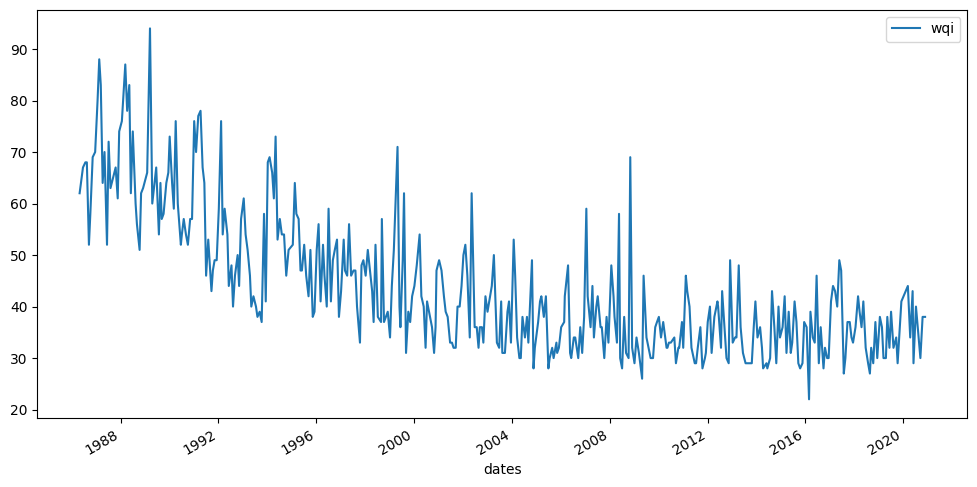

In [65]:
df=pd.read_csv('Water_dataX_mean_state_hong_kong.csv')
df=df[['water control zone','river','station','dates','wqi']]
print('choisis votre zone')
B=set()
for i in df['water control zone']:
    B.add(i)
print(B)
zone=input()
print('choisis votre rivier')
C=set()
for i in df[df['water control zone']==zone]['river']:
    C.add(i)
print(C)
river=input()
print('choisis votre station')
D=set()
for i in df[df['river']==river]['station']:
    D.add(i)
print(D)
station=input()

data = df[['dates', 'wqi']][(df['water control zone'] ==zone) & (df['river'] == river) & (df['station'] == station)]
data.to_csv('data1.csv',index=False)
df = pd.read_csv('data1.csv',index_col='dates',parse_dates=True)
df.plot(figsize=(12,6))

Epoch 1/1000
10/10 [==============================] - 11s 153ms/step - loss: 0.0085
Epoch 2/1000
10/10 [==============================] - 2s 152ms/step - loss: 0.0053
Epoch 3/1000
10/10 [==============================] - 2s 151ms/step - loss: 0.0053
Epoch 4/1000
10/10 [==============================] - 2s 231ms/step - loss: 0.0052
Epoch 5/1000
10/10 [==============================] - 2s 196ms/step - loss: 0.0056
Epoch 6/1000
10/10 [==============================] - 2s 219ms/step - loss: 0.0051
Epoch 7/1000
10/10 [==============================] - 2s 219ms/step - loss: 0.0050
Epoch 8/1000
10/10 [==============================] - 2s 154ms/step - loss: 0.0048
Epoch 9/1000
10/10 [==============================] - 2s 152ms/step - loss: 0.0051
Epoch 10/1000
10/10 [==============================] - 2s 151ms/step - loss: 0.0048
Epoch 11/1000
10/10 [==============================] - 3s 260ms/step - loss: 0.0055
Epoch 12/1000
10/10 [==============================] - 2s 169ms/step - loss: 0.0045


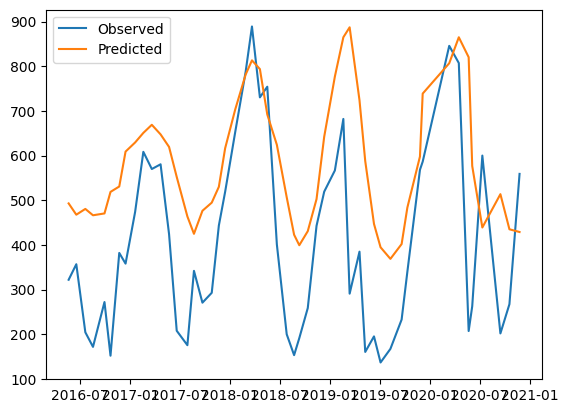

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load the data into a pandas DataFrame called df
df = pd.read_csv('data1.csv', index_col=0, parse_dates=True)

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

# Define a function to create sequences of data for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create sequences of data for LSTM
seq_length = 30
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=250, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(units=150))
model.add(Dense(units=1))


# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=1000, batch_size=32)

# Make predictions on the test data
predictions = model.predict(X_test)

# Rescale the data back to the original scale
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the observed and predicted values together
import matplotlib.pyplot as plt
plt.plot(df.index[train_size+seq_length:], y_test, label='Observed')
plt.plot(df.index[train_size+seq_length:], predictions, label='Predicted')
plt.legend()
plt.show()



### ` CNN FOR FORCASTING`

In [2]:
import pandas as pd

In [10]:
df=pd.read_csv('Water_dataX_mean_state_hong_kong.csv')
df.head(1)

,ZONE,River,Station,Dates,BOD,CONDUCTIVITY,TOTAL_PHOSPHORUS,DO,FECAL_COLIFORM,NITRATE,PH,TURBIDITY,TEMP,WQI,WQI clf
0,Junk Bay,Tseng Lan Shue Stream,JR11,4/29/1986,9.7,320.0,2.5,6.0,14206.749117,3.4,6.9,4.1,25.0,2411.184951,0


choisis votre zone
{'Western Buffer', 'DB4', 'DB7', 'Port Shelter', 'Victoria Harbour', 'North Western', 'Deep Bay', 'Southern', 'Tolo Harbour And Channel', 'Junk Bay'}
Junk Bay
choisis votre rivier
{'Tseng Lan Shue Stream'}
Tseng Lan Shue Stream
choisis votre station
{'JR6', 'JR11', 'JR3'}
JR11


<Axes: xlabel='Dates'>

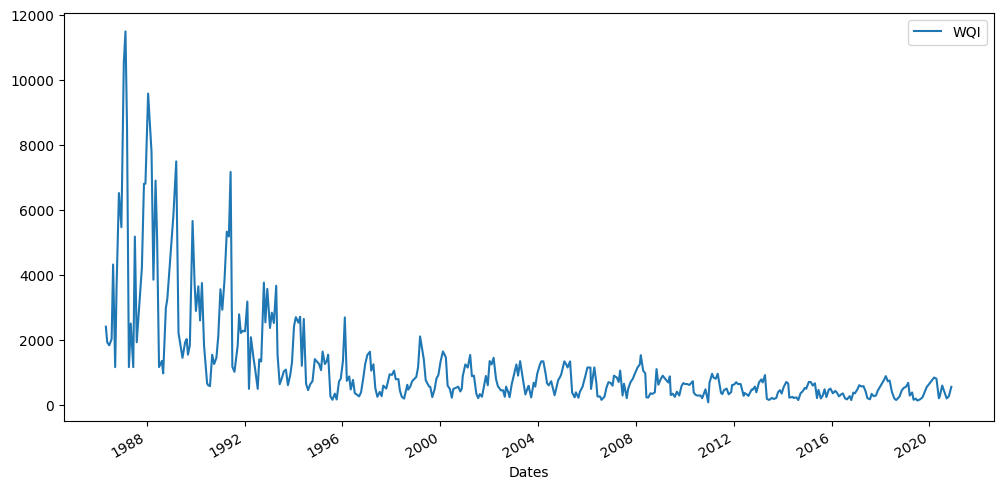

In [11]:
df=df[['ZONE','River','Station','Dates','WQI']]
print('choisis votre zone')
B=set()
for i in df['ZONE']:
    B.add(i)
print(B)
zone=input()
print('choisis votre rivier')
C=set()
for i in df[df['ZONE']==zone]['River']:
    C.add(i)
print(C)
river=input()
print('choisis votre station')
D=set()
for i in df[df['River']==river]['Station']:
    D.add(i)
print(D)
station=input()

data = df[['Dates', 'WQI']][(df['ZONE'] ==zone) & (df['River'] == river) & (df['Station'] == station)]
data.to_csv('data1.csv',index=False)
df = pd.read_csv('data1.csv',index_col='Dates',parse_dates=True)
df.plot(figsize=(12,6))

Epoch 1/1000
10/10 [==============================] - 3s 27ms/step - loss: 0.0088
Epoch 2/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0046
Epoch 3/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0041
Epoch 4/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0036
Epoch 5/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0045
Epoch 6/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0036
Epoch 7/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0033
Epoch 8/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0026
Epoch 9/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0028
Epoch 10/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0022
Epoch 11/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0020
Epoch 12/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0024
Epoch 13/1000

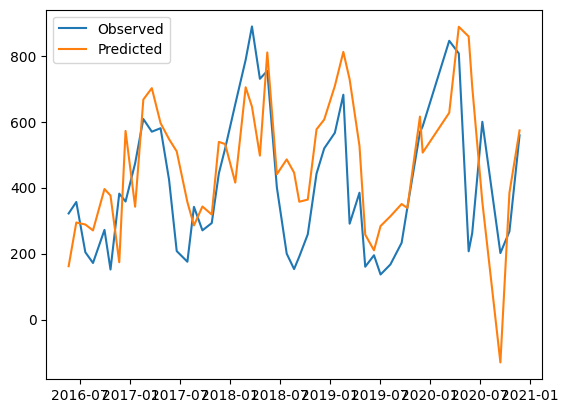

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense ,Dropout
from keras.optimizers import Adam
import time

# Load the data into a pandas DataFrame called df
df = pd.read_csv('data1.csv', index_col=0, parse_dates=True)

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

# Define a function to create sequences of data for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create sequences of data for LSTM
seq_length = 30
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Define the LSTM model
# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=128, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='linear'))


# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=1000, batch_size=32)

# Make predictions on the test data
predictions = model.predict(X_test)

# Rescale the data back to the original scale
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the observed and predicted values together
import matplotlib.pyplot as plt
plt.plot(df.index[train_size+seq_length:], y_test, label='Observed')
plt.plot(df.index[train_size+seq_length:], predictions, label='Predicted')
plt.legend()
plt.show()

